### Activity

1. Provide a shorter version of the context shown in the first assignment, in order 
to explain the data you will use in this work  
Grading criterion: 
 -  Brief contextualization (0.2 points)

## 1. Context

This project is part of an ongoing research initiative focused on the development of a low-cost atmospheric water generation system based on condensation. The main goal is to analyze environmental data to support intelligent decision-making and optimize the water generation process through predictive modeling and efficient control strategies.

Environmental data were collected in *Medellín, Colombia*, specifically in the *Las Brisas* neighborhood, which represents a typical urban outdoor setting. The measurements were carried out over a period of one week, from **March 24, 2025 at 15:27** to **March 31, 2025 at 13:30**, using an **Arduino Nano 33 BLE Sense Rev2**. This board integrates the following sensors:
- **HS3003** for temperature and humidity,
- **LPS22HB** for atmospheric pressure,
- and an external **YL-83 rain sensor**.

The sensors were fixed in position: the pressure, humidity, and temperature sensors were embedded in the Arduino board, while the rain sensor was externally mounted and send a digital signal **0 or 1**  if it is **raining or not raining** respectively. Measurements were taken every **60 seconds**, and the data were saved every **10 minutes** into a  **CSV files** using a Python script that read the values from the serial port and stored them in **OneDrive**. No abnormal environmental conditions or interference were reported during data collection.

This dataset will be used to explore the relationships between variables and to extract features relevant to the future operation of a condensation-based water generation system. Although the exact use case (e.g., agricultural or human consumption) and optimal environmental conditions are still under study, the system is expected to rely on **predictive models** to:
- anticipate rainfall events,
- identify favorable humidity/pressure/temperature conditions,
- and **optimize water production while reducing energy consumption**.

To accomplish this, we will perform data preprocessing, statistical analysis, and feature extraction using Python and scientific computing libraries. The outcomes will support future implementation of an intelligent control system for atmospheric water harvesting.

In [28]:
# We import the libreries to be used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import f_oneway, shapiro, kruskal
from scipy.integrate import cumulative_trapezoid
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


### Data loading and initial visualization. 


In [3]:
# Loading the database
file_path = "dataV2.csv"
raindf = pd.read_csv(file_path)

We first converted the timestamp column to datetime format. We then checked for missing values and duplicate entries, although none were found in this case.

In [4]:

# Convert time column to datetime format
raindf["Hora_PC"] = pd.to_datetime(raindf["Hora_PC"])

# Check if there are missing values
print("Missing values per column:\n", raindf.isna().sum())

# Drop duplicates if any
raindf = raindf.drop_duplicates()
raindf

Missing values per column:
 Hora_PC        0
Temperatura    0
Humedad        0
Presion        0
Altitud        0
Lluvia         0
dtype: int64


,Hora_PC,Temperatura,Humedad,Presion,Altitud,Lluvia
0,2025-03-24 15:27:35,32.65,38.68,84.63,16690.72,1
1,2025-03-24 15:28:33,32.88,38.05,84.64,16690.45,1
2,2025-03-24 15:29:33,32.87,38.52,84.64,16690.55,1
3,2025-03-24 15:30:33,32.58,38.16,84.63,16691.00,1
4,2025-03-24 15:31:33,32.41,37.84,84.64,16690.54,1
...,...,...,...,...,...,...
9263,2025-03-31 13:25:59,24.94,66.53,84.87,16676.05,0
9264,2025-03-31 13:26:59,24.80,70.18,84.87,16675.77,0
9265,2025-03-31 13:27:59,24.94,71.00,84.87,16675.96,0
9266,2025-03-31 13:29:00,25.16,70.60,84.87,16675.78,0


### Feature Scaling with Manual Normalization

To ensure that all input features contribute equally to the analysis, we apply a normalization to the numerical variables in the data set. This type of scaling centers each feature around a mean of 0 and scales it by its standard deviation, as shown below:

$$
x' = \frac{x - \mu}{\sigma}
$$

Using pandas, we excluded the timestamp (`Time_PC`) and the class label (`Rain`) from the transformation. The normalized values were stored in a new DataFrame (`raindf_scaled`) that retains the original structure:


In [5]:

raindf_scaled = raindf.copy()
raindf_scaled.iloc[:, 1:-1] = raindf_scaled.iloc[:, 1:-1].transform(lambda x: (x - x.mean()) / x.std())


raindf_scaled

,Hora_PC,Temperatura,Humedad,Presion,Altitud,Lluvia
0,2025-03-24 15:27:35,2.078398,-2.243462,-2.360755,2.337728,1
1,2025-03-24 15:28:33,2.141883,-2.290703,-2.287881,2.305963,1
2,2025-03-24 15:29:33,2.139123,-2.255460,-2.287881,2.317728,1
3,2025-03-24 15:30:33,2.059077,-2.282455,-2.360755,2.370670,1
4,2025-03-24 15:31:33,2.012153,-2.306451,-2.287881,2.316552,1
...,...,...,...,...,...,...
9263,2025-03-31 13:25:59,-0.049738,-0.155085,-0.611784,0.611820,0
9264,2025-03-31 13:26:59,-0.088381,0.118616,-0.611784,0.578879,0
9265,2025-03-31 13:27:59,-0.049738,0.180105,-0.611784,0.601232,0
9266,2025-03-31 13:29:00,0.010987,0.150110,-0.611784,0.580055,0


The environmental variables `temperature, humidity, and pressure`  are plotted over time.These displays help to detect trends, cycles or anomalies in environmental conditions relevant to the atmospheric water generation system, and are plotted before and after they are normalized.

- The first plot shows the raw sensor data.
- The second plot shows the same variables after applying normalization.

Normalization adjusts all variables to a comparable scale centered around zero without changing their trends. This is essential for unbiased statistical analysis and machine learning.

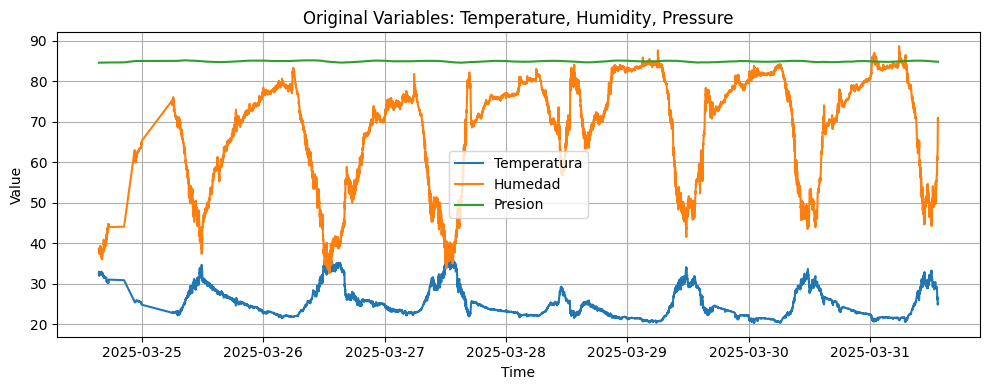

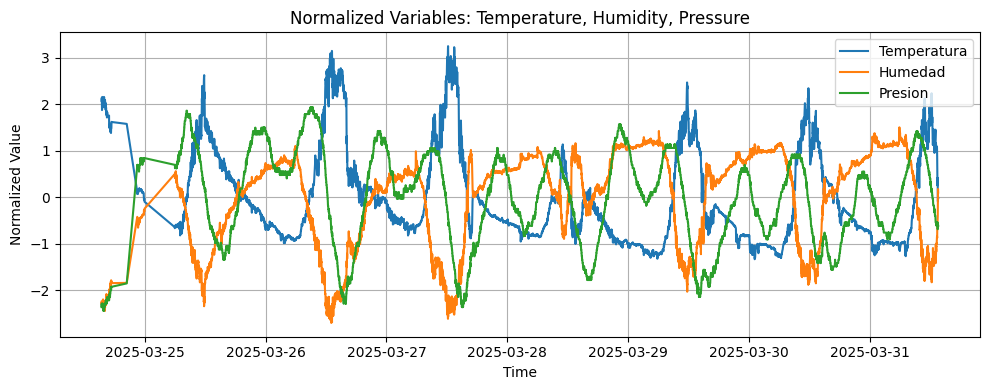

In [6]:

variables = ['Temperatura', 'Humedad', 'Presion']

# Plot 1: Original data
plt.figure(figsize=(10, 4))
for var in variables:
    plt.plot(raindf["Hora_PC"], raindf[var], label=var)
plt.title("Original Variables: Temperature, Humidity, Pressure")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Normalized data
plt.figure(figsize=(10, 4))
for var in variables:
    plt.plot(raindf_scaled["Hora_PC"], raindf_scaled[var], label=var)
plt.title("Normalized Variables: Temperature, Humidity, Pressure")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 3. Feature extraction using OOP. 
Extract relevant features to your dataset using 
the  OOP  paradigm.  Define  at  least  two  feature  domains,  for  instance, 
time/spatial  (e.g.  RMS,  energy,  intensity,  edges),  frequency  (e.g.  power 
spectrum),  or  time-frequency  (e.g.  wavelet-based  coefficients).  Ask  your 
advisor for possible candidate features to be analyzed, focusing on identifying 
key properties and patterns within the data that are relevant to your dataset’s 
context 
Grading Criteria: 
- Correct calculation and extraction of features or mathematical descriptors 
(0.7 points) 
- Brief  explanation  about  the  meaning  of  the  extracted  features  and  their 
importance for your research problem (0.3 points)

In [7]:
print("Summary of statistics:")
raindf.describe()

Summary of statistics:


,Hora_PC,Temperatura,Humedad,Presion,Altitud,Lluvia
count,9268,9268.000000,9268.000000,9268.000000,9268.000000,9268.000000
mean,2025-03-28 07:58:56.455761920,25.120194,68.598177,84.953951,16670.849604,0.686124
min,2025-03-24 15:27:35,20.300000,32.590000,84.620000,16654.340000,0.000000
25%,2025-03-26 17:29:32,22.350000,58.885000,84.860000,16663.977500,0.000000
50%,2025-03-28 08:09:41,23.970000,72.870000,84.970000,16669.720000,1.000000
75%,2025-03-29 22:49:50,27.010000,78.910000,85.060000,16676.970000,1.000000
max,2025-03-31 13:30:00,36.910000,88.710000,85.220000,16691.460000,1.000000
std,NaN,3.622889,13.335718,0.137224,8.499874,0.464092


In [8]:
class FeatureExtractor:
   
    #A class to extract time, frequency, distribution, and derivative-based features
    #from environmental signals.
   

    def __init__(self, dataframe):
        self.df = dataframe
    
        self.fs = 1  # sampling frequency in Hz

    def extract_time_features(self, columns):
        features = {}
        for i in columns:
            signal = self.df[i].values
            features[i] = {
                'mean': np.mean(signal),
                'variance': np.var(signal),
                'rms': np.sqrt(np.mean(signal**2))
            }
        return pd.DataFrame(features).T

    def extract_frequency_features(self, columns):
        features = {}
        n = len(self.df)
        freqs = np.fft.rfftfreq(n, d=1/self.fs)

        for i in columns:
            signal = self.df[i].values
            fft_vals = np.abs(np.fft.rfft(signal))
            power = fft_vals ** 2

            spectral_centroid = np.sum(freqs * power) / np.sum(power)
            spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * power) / np.sum(power))
            peak_freq = freqs[np.argmax(power)]

            features[i] = {
                'peak_freq': peak_freq,
                'spectral_centroid': spectral_centroid,
                'spectral_bandwidth': spectral_bandwidth
            }

        return pd.DataFrame(features).T

    def extract_distribution_features(self, columns):
        features = {}
        for i in columns:
            signal = self.df[i].values
            features[i] = {
                'skewness': pd.Series(signal).skew(),
                'kurtosis': pd.Series(signal).kurt()
            }
        return pd.DataFrame(features).T

    def extract_derivative_features(self, columns):
        features = {}
        for i in columns:
            signal = self.df[i].values
            diff = np.diff(signal)
            features[i] = {
                'mean_abs_change': np.mean(np.abs(diff)),
                'std_derivative': np.std(diff)
            }
        return pd.DataFrame(features).T
    


En esta sección, hemos implementado una clase `FeatureExtractor` personalizada utilizando programación orientada a objetos (POO). Esta clase se diseñó para extraer características clave de señales ambientales como la temperatura, la humedad y la presión.
Nos centramos en cuatro dominios de características:

#### 1. Características del dominio temporal
- **Media**: El valor medio de la señal a lo largo del tiempo.
- **Varianza**: La dispersión o fluctuación de los valores de la señal.
- **RMS (media cuadrática)**: Mide la magnitud media de la señal, a menudo interpretada como la «potencia» de la señal.»

**Interpretación**: Una alta varianza o RMS sugiere una señal variable o enérgica; valores bajos indican estabilidad.

#### 2. Características en el dominio de la frecuencia
- **Frecuencia de pico**: La frecuencia dominante en la señal, obtenida mediante FFT.
- **Centroide espectral**: El centro de masa del espectro de frecuencias.
- **Ancho de banda espectral**: Mide la dispersión del contenido frecuencial.

**Interpretación Las señales con un centroide espectral o un ancho de banda mayores cambian más rápidamente. Los valores bajos indican señales estables o que varían lentamente.

#### 3. Distribution Features (First-order statistics)
- **Skewness**: Measures asymmetry. Positive values indicate a right tail; negative values a left tail.
- **Kurtosis**: Measures the "peakedness" of the signal distribution. High kurtosis implies outliers; low kurtosis implies flatness.

**Interpretation**: Useful for understanding the shape of the signal distribution and detecting outliers or skewed behavior.

#### 4. Derivative-Based Features
- **Mean Absolute Change**: Average of the absolute differences between consecutive points.
- **Standard Deviation of Derivative**: Indicates how variable the signal changes are.

**Interpretation**: High values suggest that the signal changes frequently or abruptly over time, reflecting instability or rapid transitions.


In [9]:
columns = ['Temperatura', 'Humedad', 'Presion']

extractor = FeatureExtractor(raindf)

time_feats = extractor.extract_time_features(columns)
freq_feats = extractor.extract_frequency_features(columns)
shape_feats = extractor.extract_distribution_features(columns)
deriv_feats = extractor.extract_derivative_features(columns)
print(f'-the time_features are: \n{ time_feats}\n')
print(f'-the frequency_features are: \n{ freq_feats} \n')
print(f'-the distribution_features are: \n{ shape_feats}\n')
print(f'-the derivative_features are: \n{ deriv_feats}')



-the time_features are: 
                  mean    variance        rms
Temperatura  25.120194   13.123907  25.380072
Humedad      68.598177  177.822195  69.882273
Presion      84.953951    0.018828  84.954062

-the frequency_features are: 
             peak_freq  spectral_centroid  spectral_bandwidth
Temperatura        0.0       1.993442e-05            0.001207
Humedad            0.0       2.952015e-05            0.001611
Presion            0.0       2.116639e-09            0.000011 

-the distribution_features are: 
             skewness  kurtosis
Temperatura  1.053572  0.319297
Humedad     -0.807974 -0.494100
Presion     -0.345885 -0.708501

-the derivative_features are: 
             mean_abs_change  std_derivative
Temperatura         0.124624        0.222317
Humedad             0.448187        0.752668
Presion             0.002609        0.006257


#### Summary

The extracted features allow us to characterize environmental variables from different analytical perspectives. For example:

- **Humidity** showed high variability and dynamics, both in the temporal and derived domains.
- **Temperature** was relatively stable but showed a slight asymmetry in its distribution.
- **Pressure** was nearly constant across all metrics, indicating that it may have limited relevance for moisture prediction.

These descriptors will later serve as a basis for building prediction models.

### 4. Statistical analysis of custom data and feature extraction. 
Conduct a statistical analysis  of  your  feature  space.  Calculate  and  interpret  relevant  summary 
statistics  (e.g.,  mean,  median,  variance)  and  distributions  for  the  chosen 
features,  and  display  the  results  visually  where  applicable.  Make  that  the 
dataset includes multiple categories or classes, apply statistical tests (e.g., t-
tests, ANOVA,  Fisher’s  ratio) to determine differences across groups. 
Perform an analysis of how distinct or separable different groups or categories 
are within your dataset, both visually and numerically. 
Grading Criteria: 
- Correct calculation  and  application  of  statistical  measures/tests  (0.5 
points) 
- Clear visualizations and meaningful interpretations relevant to the dataset 
(0.5 points) 
- Clear  interpretation  of  separability  measurements  in  the  context  of  the 
dataset (0.4 points)

In [10]:
# Summary statistics grouped by rain condition
summary_stats = raindf.groupby('Lluvia')[['Temperatura', 'Humedad', 'Presion']].agg(['mean', 'median', 'std'])
summary_stats


Temperatura                     Humedad                      Presion  \
              mean median       std       mean median        std       mean   
Lluvia                                                                        
0        22.952310  22.53  1.780286  78.162888  79.45   6.034604  84.954476   
1        26.111919  25.06  3.814057  64.222686  68.25  13.474012  84.953711   

                         
       median       std  
Lluvia                   
0       84.96  0.105407  
1       84.98  0.149546

#### Summary Statistics by Rain Condition

We computed the mean, median, and standard deviation for temperature, humidity, and pressure, grouped by the rain label (`Lluvia`: 0 = rain, 1 = no rain).

##### Key Observations:
- **Temperature** is noticeably lower when it rains (mean: 22.95°C vs 26.11°C), suggesting a clear correlation between rainfall and cooler conditions.
- **Humidity** is higher during rainfall (mean: 78.16% vs 64.22%), which is expected and confirms the sensor reliability.
- **Pressure** remains almost constant across both groups, indicating it may not be a strong predictor for rainfall in this dataset.

These patterns help identify environmental signatures associated with rain events

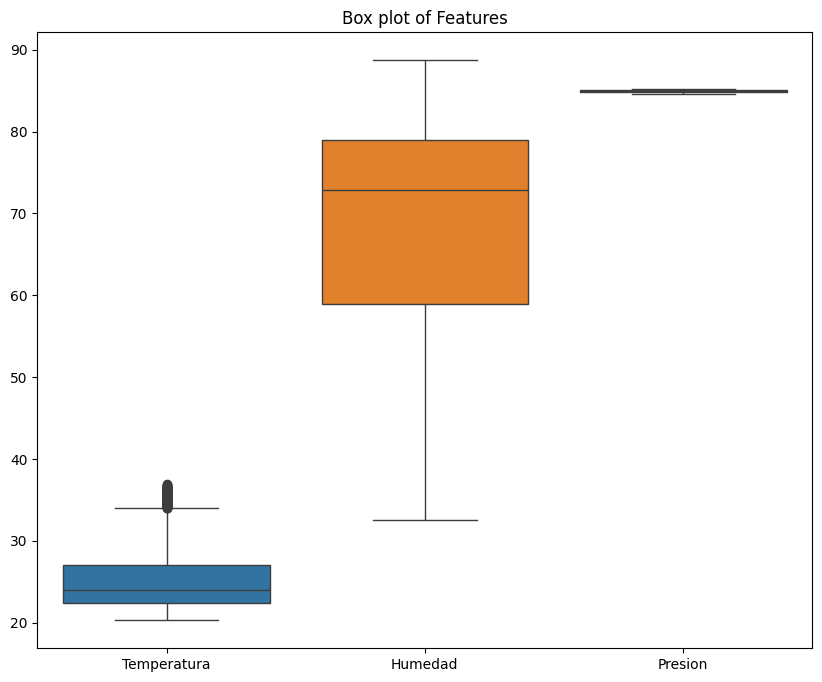

In [11]:
# Box plot of each feature
plt.figure(figsize=(10, 8))
sns.boxplot(data=raindf.iloc[:, 1:-2])
plt.title("Box plot of Features")
plt.show()

### Box Plot of Environmental Characteristics

The above box plot illustrates the distribution of **Temperature**, **Humidity** and **Pressure**. Temperature shows a tighter distribution with a few outliers, while humidity shows a wider distribution. Pressure is highly concentrated, with minimal variation in the data set.


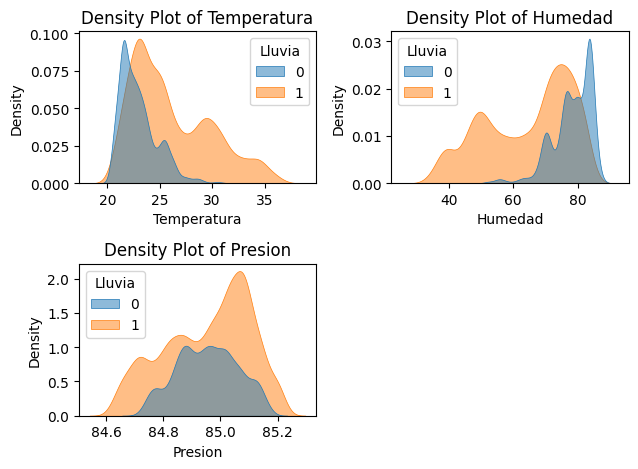

In [12]:
for i, feature in enumerate(['Temperatura', 'Humedad', 'Presion']):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(data=raindf, x=feature, hue='Lluvia', fill=True, alpha=0.5, linewidth=0.5)
    plt.title(f'Density Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Density Plots by Rainfall Category

The above density plots show the distribution of **Temperature**, **Humidity**, and **Pressure**, grouped by the `Lluvia` (Rain) variable. 

- Temperature and humidity distributions show noticeable shifts between rain (`Lluvia = 1`) and no rain (`Lluvia = 0`), suggesting they may help distinguish between the two conditions.
- Pressure distributions for both classes are very close, indicating it might be less discriminative for rainfall prediction.

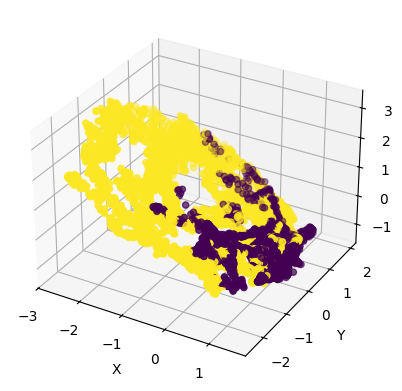

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter( raindf_scaled['Humedad'], raindf_scaled['Presion'],raindf_scaled['Temperatura'],  c=raindf_scaled['Lluvia'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

C:\Users\juane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\juane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\juane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (3) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\juane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sea

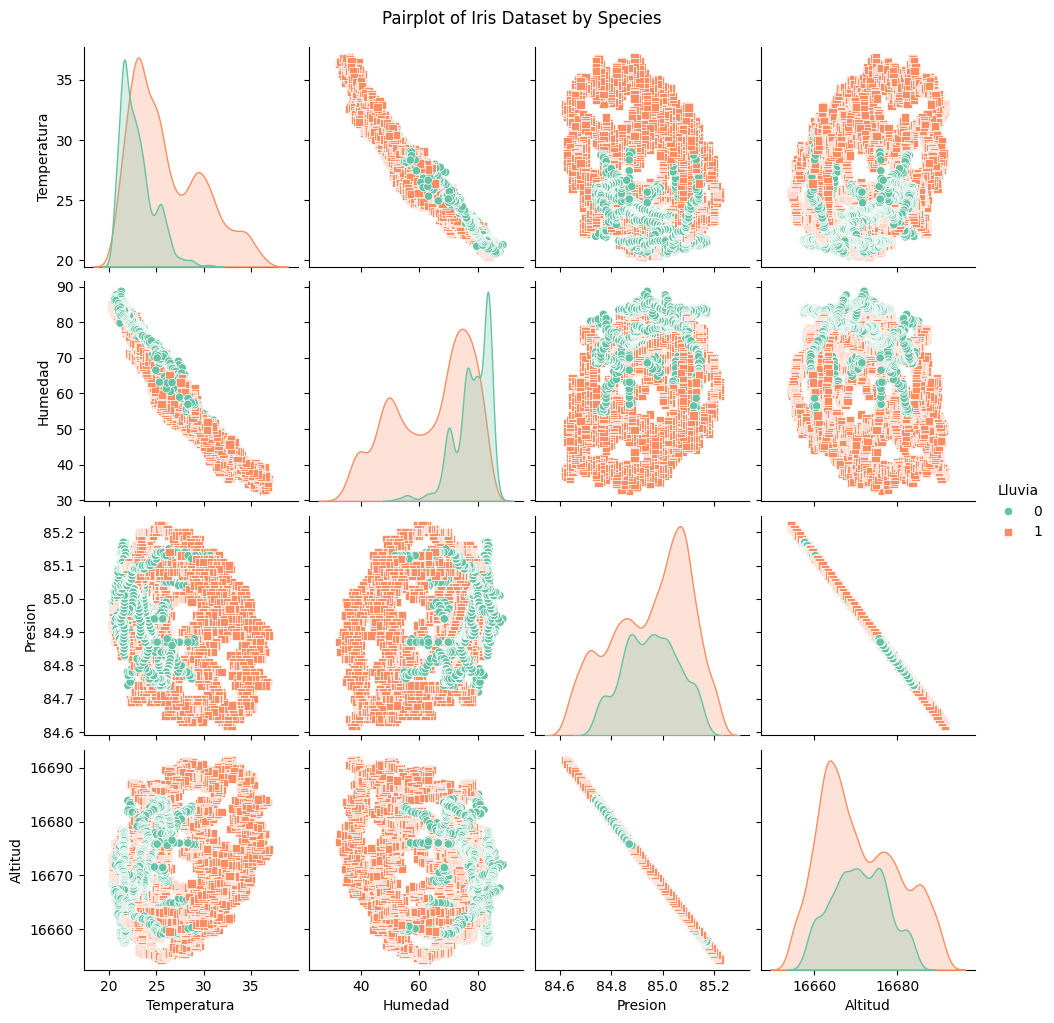

In [14]:
sns.pairplot(raindf, hue='Lluvia', palette='Set2', markers=["o", "s", "D"], diag_kind='kde')
plt.suptitle("Pairplot of Iris Dataset by Species", y=1.02)
plt.show()

### Multivariate analysis graphs.

Two visualizations were created to allow us to explore the relationship between meteorological variables and the presence of rainfall:

- **3D scatterplot**: This plot visualizes the normalized characteristics - Humidity, Pressure and Temperature - in a 3D space, with points of different colors according to the class “Rainfall”. Some clustering patterns are visible, suggesting a potential for classification although it is not very clear.

- **Pair plot**: This plot matrix shows all pairwise relationships between features, along with KDE distributions by class. In particular, there is a strong inverse relationship between humidity and temperature, and clear separations can be seen between rainy and non-rainy conditions.

- These plots support the hypothesis that the features contain useful patterns to distinguish between rainy and non-rainy situations, but it is not yet perfect and new features should be sought to increase separability.

In [18]:

# Define the features to evaluate
features = ['Temperatura', 'Humedad', 'Presion', 'Altitud']

# Separate the dataset into the two classes: 0 = Rain, 1 = No Rain
group0 = raindf[raindf['Lluvia'] == 0]
group1 = raindf[raindf['Lluvia'] == 1]

# Dictionary to store Fisher's ratio per feature
fisher_scores = {}

# Compute Fisher's Discriminant Ratio for each feature
for feature in features:
    mean0 = group0[feature].mean()
    mean1 = group1[feature].mean()
    var0 = group0[feature].var()
    var1 = group1[feature].var()
    
    # Fisher Ratio formula: (mean difference squared) / (sum of variances)
    fisher_ratio = ((mean0 - mean1) ** 2) / (var0 + var1)
    fisher_scores[feature] = fisher_ratio

# Convert results to a DataFrame for visualization
fisher_df = pd.DataFrame.from_dict(fisher_scores, orient='index', columns=['Fisher_Ratio'])
fisher_df = fisher_df.sort_values(by='Fisher_Ratio', ascending=False)

# Display the Fisher scores
print("Fisher’s Discriminant Ratio per feature:\n")
fisher_df

Fisher’s Discriminant Ratio per feature:



,Fisher_Ratio
Humedad,0.891560
Temperatura,0.563495
Altitud,0.000025
Presion,0.000017


### Fisher's Discriminant Ratio Analysis

To evaluate how well each feature separates the two rainfall classes (`Lluvia = 0` and `Lluvia = 1`), we calculated the Fisher’s Discriminant Ratio (FDR) for all variables.

The results indicate that **Humidity** is the most discriminative feature, followed by **Temperature**. These two variables provide meaningful class separation, making them relevant for future classification models. In contrast, **Altitude** and **Pressure** have extremely low Fisher scores, suggesting they do not contribute significantly to distinguishing between rain and no-rain conditions.


In [25]:

print("ANOVA (F-test) results comparing Lluvia = 0 vs Lluvia = 1:\n")

for feature in features:
    # Create a list of feature values grouped by class (0 and 1)
    feature_values = [
        raindf[raindf['Lluvia'] == i][feature].values for i in [0, 1]
    ]
    
    f_statistic, p_value = f_oneway(*feature_values)
    print(f"{feature}: F-statistic = {f_statistic:.4f}, p-value = {p_value:.6f}")

ANOVA (F-test) results comparing Lluvia = 0 vs Lluvia = 1:

Temperatura: F-statistic = 1815.3309, p-value = 0.000000
Humedad: F-statistic = 2851.9490, p-value = 0.000000
Presion: F-statistic = 0.0619, p-value = 0.803457
Altitud: F-statistic = 0.0890, p-value = 0.765408


### ANOVA Results

We apply Analysis of Variance **ANOVA** to the dataset to evaluate the significance of each feature with respect to the target variable (`Lluvia = 0` and `Lluvia = 1`)

The results confirm that **Temperature** and **Humidity** exhibit highly significant differences between the two classes, as their p-values are effectively zero. This indicates that these features are statistically relevant for distinguishing between rain and no-rain conditions.

In contrast, **Pressure** and **Altitude** show high p-values and very low F-statistics, suggesting no meaningful difference in their means across the classes. These variables may therefore be less useful for predictive modeling in this context.

### 5. Data separability. 
Compute performance  metrics relevant to your data 
analysis goals. For datasets with labels, calculate classification performance 
metrics such as accuracy, precision, recall, F1-score, or ROC-AUC for your 
model.  For  continuous  or  time-series  datasets,  define  performance  metrics 
relevant to your dataset (e.g., root-mean-square error, correlation coefficient, 
or  spectral  match)  and  evaluate  how  well  data  transformations  or  models 
meet these metrics. 
Grading Criteria: 
- Correct implementation and calculation of appropriate performance 
metrics (0.6 points) 
- Insightful interpretation and comparison of performance results (0.8 
points)

In [29]:
X = raindf[features]
y = raindf['Lluvia']

# Split data into train and test (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


In [30]:
# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Print results
print("Logistic Regression performance metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

Logistic Regression performance metrics:
Accuracy:  0.8495
Precision: 0.8745
Recall:    0.9122
F1-score:  0.8930
ROC-AUC:   0.9205


### Logistic Regression Performance Metrics

A Logistic Regression model was trained on environmental features to classify rainfall conditions (`Lluvia`).

The model shows strong performance, with high recall and precision indicating effective identification of rain events. The ROC-AUC score above 0.9 suggests excellent separability between rain and no-rain classes, confirming that the selected features provide meaningful information for rainfall prediction.

### Conclusion on Data Separability and Model Performance

This study demonstrates that the environmental variables collected—primarily temperature and humidity—provide significant discriminatory power to distinguish between rain and no-rain conditions.

The logistic regression classifier, trained on these features, achieved robust performance metrics, including an accuracy of approximately 85%, precision and recall above 87% and 91% respectively, and an ROC-AUC exceeding 0.92. These results indicate a high degree of separability within the dataset.